<a href="https://user.oc-static.com/upload/2020/11/24/16062164030098_image2.png" target="_blank">
  <img src="https://user.oc-static.com/upload/2020/11/24/16062164030098_image2.png" alt="Description de l'image">
</a>


# <font color='indianred'>Produisez une étude de marché avec R ou Python</font>

  ## <font color='indianred'> Sommaire<font></a>
    
**Notebook 2 - Clustering - visualisation**
    

    
### <a href="#C1"> 1 - Import des données</a><font></a>
### <a href="#C2"> 2 - Fonctions utiles</a><font></a>
### <a href="#C3"> 3 - Clustering</a><font></a>
    
- <a href="#C4">3.1 Clustering par la méthode du Classification hiérarchique ascendante (CAH)</a> 
- <a href="#C5">3.2 Standardisation des données</a> 
- <a href="#C6">3.3 Clustering par la méthode K_means</a> 
- <a href="#C7">3.4 Quelle méthode de clustering choisir ?</a> 
- <a href="#C8">3.5 Conclusion</a>   

## <font color='indianred'>Partie 5 - Clustering et visualisations</font>

## <a name="C1"><font> 1 - Import des données</font></a>

In [40]:
# Importation des librairies
import pandas as pd
import numpy as np

from math import pi

import matplotlib.pyplot as plt
from matplotlib import cm
import plotly.express as px
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import KElbowVisualizer

In [41]:
pip install yellowbrick

Note: you may need to restart the kernel to use updated packages.


## <a name="C2"><font> 2 - Fonctions utiles</font></a>

In [42]:
# Fonction pour générer un radar plot par ligne du dataframe

def make_spider(data, group, row, title, color):

    # number of variable
    categories=list(data)[1:]
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # define number of subplot
    if len(data.index)%2 !=0:
        line = round((len(data.index)+1)/2)
    else:
         line = round(len(data.index)/2)
    
    # Initialise the spider plot
    ax = plt.subplot(line,2,row+1, polar=True, )

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='grey', size=8)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.ylim(-2.1,2.3)

    # Ind1
    values=data.loc[row].drop(group).values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)

    # Add a title
    plt.title(title, size=11, color=color, y=1.1)
    
    plt.tight_layout()



In [43]:
# On récupère le fichier final issu du nettoyage
df_final = pd.read_csv("df_final.csv")

# On récupère les données centrées-réduites
df_x_scaled = pd.read_csv("df_X_scaled.csv")

In [44]:
df_final.set_index('pays', inplace=True)
df_final

,Exportations poulet,Importations poulet,Production poulet,dispo_al,taux consommation volaille,Population en 2017,stabilité politique,pib par habitant
pays,,,,,,,,
Afghanistan,0.000000,0.798984,0.771432,1997,0.250376,10.499466,-2.80,530.149831
Afrique du Sud,1.105074,9.016001,29.240609,2987,4.787412,10.950978,-0.28,6723.928582
Albanie,0.000000,13.175372,4.507364,3400,2.500000,7.966992,0.38,4521.752219
Algérie,0.000000,0.048322,6.644247,3345,0.657698,10.630775,-0.92,4134.936054
Allemagne,7.815297,10.186501,18.316346,3559,1.994942,11.322472,0.59,44670.222288
...,...,...,...,...,...,...,...,...
Émirats arabes unis,9.908084,45.640427,5.059447,3370,4.362018,9.157699,0.62,42522.377622
Équateur,0.000000,0.000000,20.255745,2585,3.210832,9.728262,-0.07,6246.404252
États-Unis d'Amérique,11.357038,0.378363,67.410113,3762,5.821372,12.691841,0.29,59059.596403


## <a name="C3"><font> 3 - Clustering</font></a> 
- **Nous utiliserons deux techniques de clustering distinctes pour voir si elles produisent des résultats différents. Le but du clustering est d'identifier les  différents groupes de pays. Une fois ces groupes sont identifiés, nous choisirons un comme  référence pour nos travaux futurs.**

### <a name="C4"> 3.1 Clustering par la méthode du Classification hiérarchique ascendante (CAH) </a>
     Utilisation du package «scipy»
**La Classification Hiérarchique Ascendante (CAH) utilisant la méthode de Ward commence par traiter chaque point de données comme son propre cluster. Ensuite, en suivant une approche itérative, les clusters sont fusionnés deux à deux de manière à minimiser la réduction de l'inertie intra-cluster. Le processus continue jusqu'à ce que toutes les données soient regroupées en un seul cluster. Les étapes de cette agglomération sont souvent visualisées à l'aide d'un dendrogramme.**

### <a name="C5"> 3.2 Standardisation des données</a>
**On va centrer et réduire les données pour avoir une moyenne égale à 0 et un écart type égale à 1 pour chaque variable.**

In [45]:
# On récupère les valeurs du dataframe df_scaled
X_scaled = df_x_scaled.values

# On utilise linkage pour calculer la distance entre les points et les relier entre eux
Z = linkage(X_scaled, method="ward",metric='euclidean')

X_scaled[:3]

array([[ 0.        , -0.32315231, -0.52616581, -0.88187602, -1.87037775,
        -1.08115067,  0.79657101, -3.03534231, -0.68380728],
       [ 1.        , -0.20592533, -0.07774204,  0.79289876,  0.2912504 ,
         1.10682105,  1.03574805, -0.22769904, -0.36085619],
       [ 2.        , -0.32315231,  0.14924557, -0.66209993,  1.19302053,
         0.0037237 , -0.5449436 ,  0.5076361 , -0.47568032]])

In [46]:
#Centrage / réduction des données pour que nos données puissent prendre la même importance

X = df_final.select_dtypes(exclude= ['object']).values  # Matrice des données(Transformation en array Numpy)
names = df_final.index # Noms des individus
features = df_final.select_dtypes(exclude=['object']).columns # Noms des variables

p = df_final.shape[1] # nb de variables

#Instanciation et application du scaler

scaler = StandardScaler() # Instanciation du scaler
X_scaled = scaler.fit_transform(X) # Données scalées(centrer et réduire)

# Analyse en Composantes principales
n_components =5# Nombre de composantes principales 
pca = PCA(n_components=n_components) # Instanciation de l'ACP
X_proj = pca.fit_transform(X_scaled) # Entraînement et application du modèle sur les données scalées

#Clustering hiérarchique: création d'une Matrice des liens selon la Méthode de Ward
Z = linkage(X_proj, method = 'ward', metric='euclidean')
X_scaled[:3]


array([[-0.32315231, -0.52616581, -0.88187602, -1.87037775, -1.08115067,
         0.79657101, -3.03534231, -0.68380728],
       [-0.20592533, -0.07774204,  0.79289876,  0.2912504 ,  1.10682105,
         1.03574805, -0.22769904, -0.36085619],
       [-0.32315231,  0.14924557, -0.66209993,  1.19302053,  0.0037237 ,
        -0.5449436 ,  0.5076361 , -0.47568032]])

In [47]:
scree = pd.DataFrame(
    {
        "Dimension" : ["PC" + str(x + 1) for x in range(5)], 
        "Variance expliquée" : pca.explained_variance_,
        "% variance expliquée" : np.round(pca.explained_variance_ratio_ * 100),
        "% cum. var. expliquée" : np.round(np.cumsum(pca.explained_variance_ratio_) * 100)
    }
)
scree

,Dimension,Variance expliquée,% variance expliquée,% cum. var. expliquée
0,PC1,3.111528,39.0,39.0
1,PC2,1.836777,23.0,61.0
2,PC3,1.006879,13.0,74.0
3,PC4,0.939345,12.0,86.0
4,PC5,0.479551,6.0,92.0


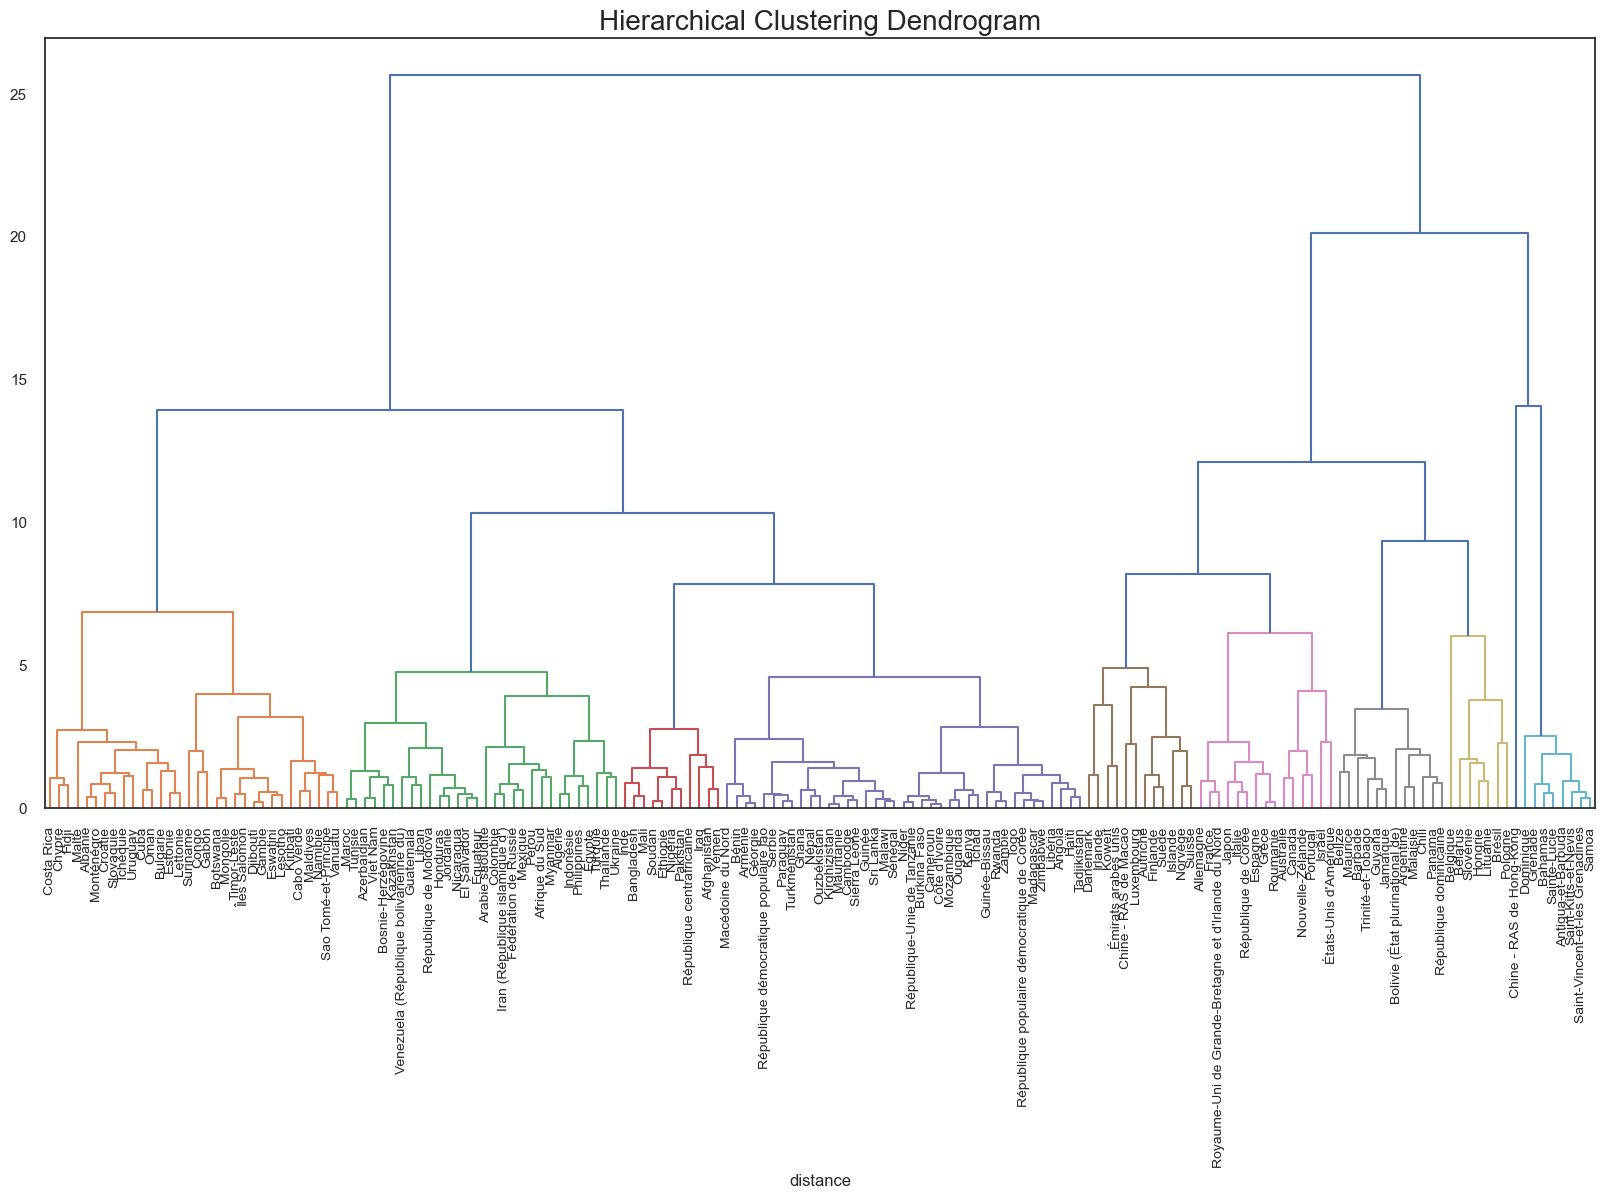

In [48]:
#Affichage d'un premier dendrogramme global
fig =plt.figure(figsize=(20,10))
sns.set_style('white')
plt.title('Hierarchical Clustering Dendrogram', fontsize=20)
plt.xlabel('distance')
dendrogram(Z,labels = names, leaf_font_size=10, color_threshold=7, orientation='top')
plt.show()

In [49]:
# définition du nombre de clusters k
k = 5

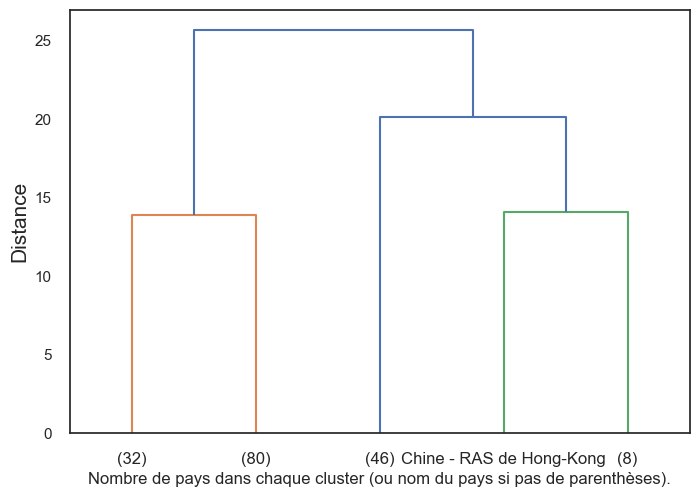

In [50]:
#Coupage du dendrogramme en 5 groupes pour avoir une première idée du partitionnement
plt.xlabel("Nombre de pays dans chaque cluster (ou nom du pays si pas de parenthèses).")
plt.ylabel("Distance", fontsize=15)
dendrogram(Z, labels = df_final.index, p=5, truncate_mode='lastp', leaf_font_size=12, orientation='top')
plt.show()

In [51]:
# Identification des clusters
clusters = fcluster(Z, 5, criterion='maxclust')
print('Numérotation de nos groupes : ' + str(np.unique(clusters)))

Numérotation de nos groupes : [1 2 3 4 5]


**Il apparait 5 groupes de pays dont un contenant seulement 8 pays. Voyons comment se présentent ces pays dans leurs groupes.** 

### <font color='indianred'>Projection des clusters sur le premier plan factoriel</font>

In [52]:
# Coordonnées des centroïdes
cent_CAH_proj = pd.DataFrame(X_proj)
cent_CAH_proj['Cluster_CAH'] = clusters
cent_CAH_proj = cent_CAH_proj.groupby('Cluster_CAH').mean()
cent_CAH_proj

,0,1,2,3,4
Cluster_CAH,,,,,
1,0.081840,0.944964,-0.084498,0.513948,0.521186
2,-1.379730,-0.141599,0.167352,-0.141978,-0.131417
3,1.701921,-1.092533,-0.341919,0.147523,0.006336
4,2.817160,3.765898,-0.437925,-1.085336,-0.890811
5,6.933905,1.218419,8.547392,-3.191512,0.670390


- A partir des centroïdes calculés ci-dessus,on peut constater que: 
- **le cluster 1** se caractérise par une forte population ainsi qu'un pib par habitant très faible
- **le cluster 3** se différencie par un fort taux d'importation de poulet ainsi qu'un taux de consommation de volaille important et une population faible(les îles).
- **Le cluster 4** présente également un potentiel marché intéressant toujours sur l'idée d'un régime alimentaire potentiellement compatible avec les besoins en poulet:ce dernier est éventuellemnt intéressant pour notre étude.
- **le cluster 5** présente des pays qui sont des gros producteurs et exportateurs de poulet:ce cluster nous interesse moins car le taux d'importation est faible.

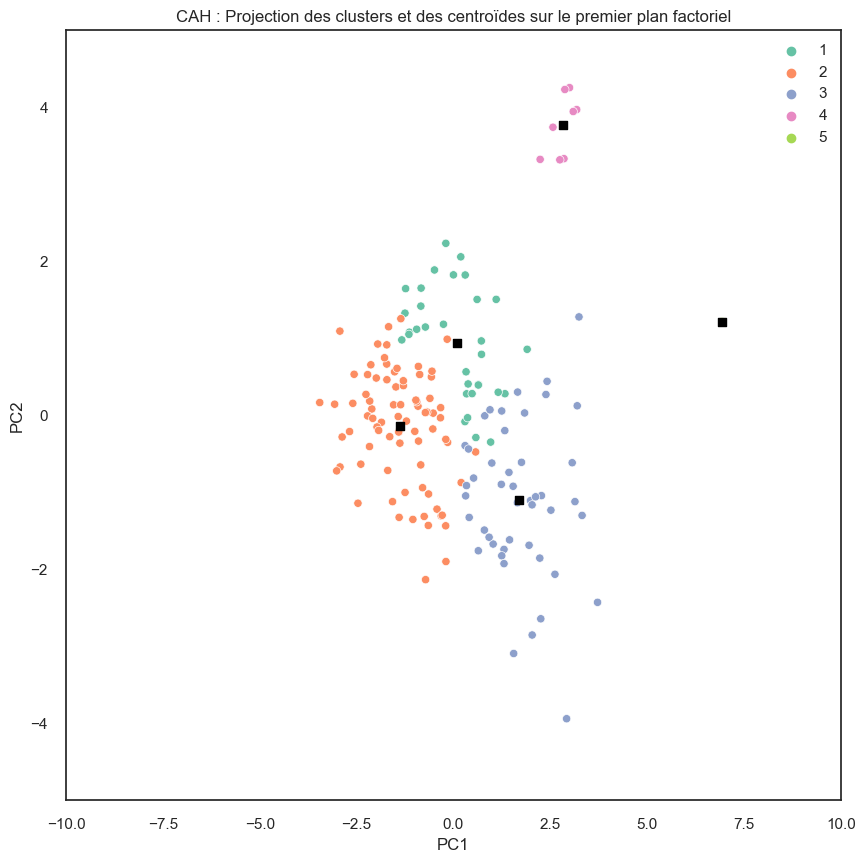

In [53]:
fig, ax = plt.subplots(1,1, figsize=(10,10))  # Définition figure et axe

sns.scatterplot(data=None, x=X_proj[:, 0], y=X_proj[:, 1], 
                hue=clusters, palette='Set2', ax=ax)  # Affichage des individus

ax.scatter(cent_CAH_proj.iloc[:, 0], cent_CAH_proj.iloc[:, 1],
           marker="s", c="black")  # Affichage des centroïdes avec matplotlib

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_title("CAH : Projection des clusters et des centroïdes sur le premier plan factoriel")
plt.xlim(-10,10)
plt.ylim(-5,5)
plt.show()

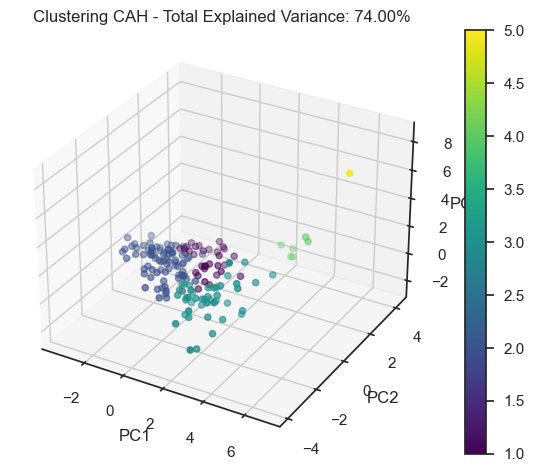

In [54]:
# Créer une nouvelle figure
fig = plt.figure()

# Ajouter des axes 3D
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
sc = ax.scatter(X_proj[:, 0], X_proj[:, 1], X_proj[:, 2], c=clusters, cmap='viridis')

# Ajouter des labels et un titre
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.title(f'Clustering CAH - Total Explained Variance: {scree.iloc[2,3]:.2f}%')

# Afficher la colorbar
plt.colorbar(sc)

# Montrer le plot
plt.show()

### <font color='indianred'>Identification des pays de chaque cluster</font>

In [55]:
# Création d'un dataframe avec les clusters du CAH
df_CAH = df_final.copy()
df_CAH['cluster_CAH'] = clusters
df_CAH

,Exportations poulet,Importations poulet,Production poulet,dispo_al,taux consommation volaille,Population en 2017,stabilité politique,pib par habitant,cluster_CAH
pays,,,,,,,,,
Afghanistan,0.000000,0.798984,0.771432,1997,0.250376,10.499466,-2.80,530.149831,2
Afrique du Sud,1.105074,9.016001,29.240609,2987,4.787412,10.950978,-0.28,6723.928582,2
Albanie,0.000000,13.175372,4.507364,3400,2.500000,7.966992,0.38,4521.752219,1
Algérie,0.000000,0.048322,6.644247,3345,0.657698,10.630775,-0.92,4134.936054,2
Allemagne,7.815297,10.186501,18.316346,3559,1.994942,11.322472,0.59,44670.222288,3
...,...,...,...,...,...,...,...,...,...
Émirats arabes unis,9.908084,45.640427,5.059447,3370,4.362018,9.157699,0.62,42522.377622,3
Équateur,0.000000,0.000000,20.255745,2585,3.210832,9.728262,-0.07,6246.404252,2
États-Unis d'Amérique,11.357038,0.378363,67.410113,3762,5.821372,12.691841,0.29,59059.596403,3


In [57]:
# Liste des pays de chaque cluster
for i in range(1,k+1):
    print('CAH - Cluster '+str(i)+': '+str(len(df_CAH.loc[df_CAH['cluster_CAH']==i].index))+' pays')
    print(df_CAH.loc[df_CAH['cluster_CAH']==i].index)    
    print('-'*100)

CAH - Cluster 1: 32 pays
Index(['Albanie', 'Botswana', 'Bulgarie', 'Cabo Verde', 'Chypre', 'Congo',
       'Costa Rica', 'Croatie', 'Cuba', 'Djibouti', 'Estonie', 'Eswatini',
       'Fidji', 'Gabon', 'Gambie', 'Kiribati', 'Lesotho', 'Lettonie',
       'Maldives', 'Malte', 'Mongolie', 'Monténégro', 'Namibie', 'Oman',
       'Sao Tomé-et-Principe', 'Slovaquie', 'Suriname', 'Tchéquie',
       'Timor-Leste', 'Uruguay', 'Vanuatu', 'Îles Salomon'],
      dtype='object', name='pays')
----------------------------------------------------------------------------------------------------
CAH - Cluster 2: 80 pays
Index(['Afghanistan', 'Afrique du Sud', 'Algérie', 'Angola', 'Arabie saoudite',
       'Arménie', 'Azerbaïdjan', 'Bangladesh', 'Bosnie-Herzégovine',
       'Burkina Faso', 'Bénin', 'Cambodge', 'Cameroun', 'Colombie',
       'Côte d'Ivoire', 'El Salvador', 'Fédération de Russie', 'Ghana',
       'Guatemala', 'Guinée', 'Guinée-Bissau', 'Géorgie', 'Haïti', 'Honduras',
       'Inde', 'Indonési

### <font color='indianred'>Analyse des Centroïdes</font>

In [58]:
# Convertir seulement les colonnes numériques en array numpy
X = df_final.select_dtypes(exclude=['object']).values

# Utilisation de StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convertir le résultat en DataFrame et utiliser l'index de df_final
df_scaled = pd.DataFrame(X_scaled, columns=features, index=df_final.index)

# Ajouter les clusters
df_scaled['cluster_CAH'] = clusters

# Calculer les moyennes des clusters
cent_CAH_df = df_scaled.groupby(['cluster_CAH']).mean()
cent_CAH_df

,Exportations poulet,Importations poulet,Production poulet,dispo_al,taux consommation volaille,Population en 2017,stabilité politique,pib par habitant
cluster_CAH,,,,,,,,
1,-0.132657,0.153087,-0.462793,-0.168846,-0.245586,-0.863726,0.555335,-0.254410
2,-0.277161,-0.414045,-0.380208,-0.412207,-0.528074,0.531322,-0.759703,-0.539373
3,0.428265,-0.082333,1.121692,0.900816,0.590873,0.062135,0.712784,1.078261
4,-0.323152,3.225912,-0.704724,-0.518541,2.638266,-2.209024,1.151054,0.002195
5,9.302960,6.204820,-0.734019,1.090398,1.818442,-0.052563,1.009001,1.673358


<AxesSubplot:xlabel='cluster_CAH'>

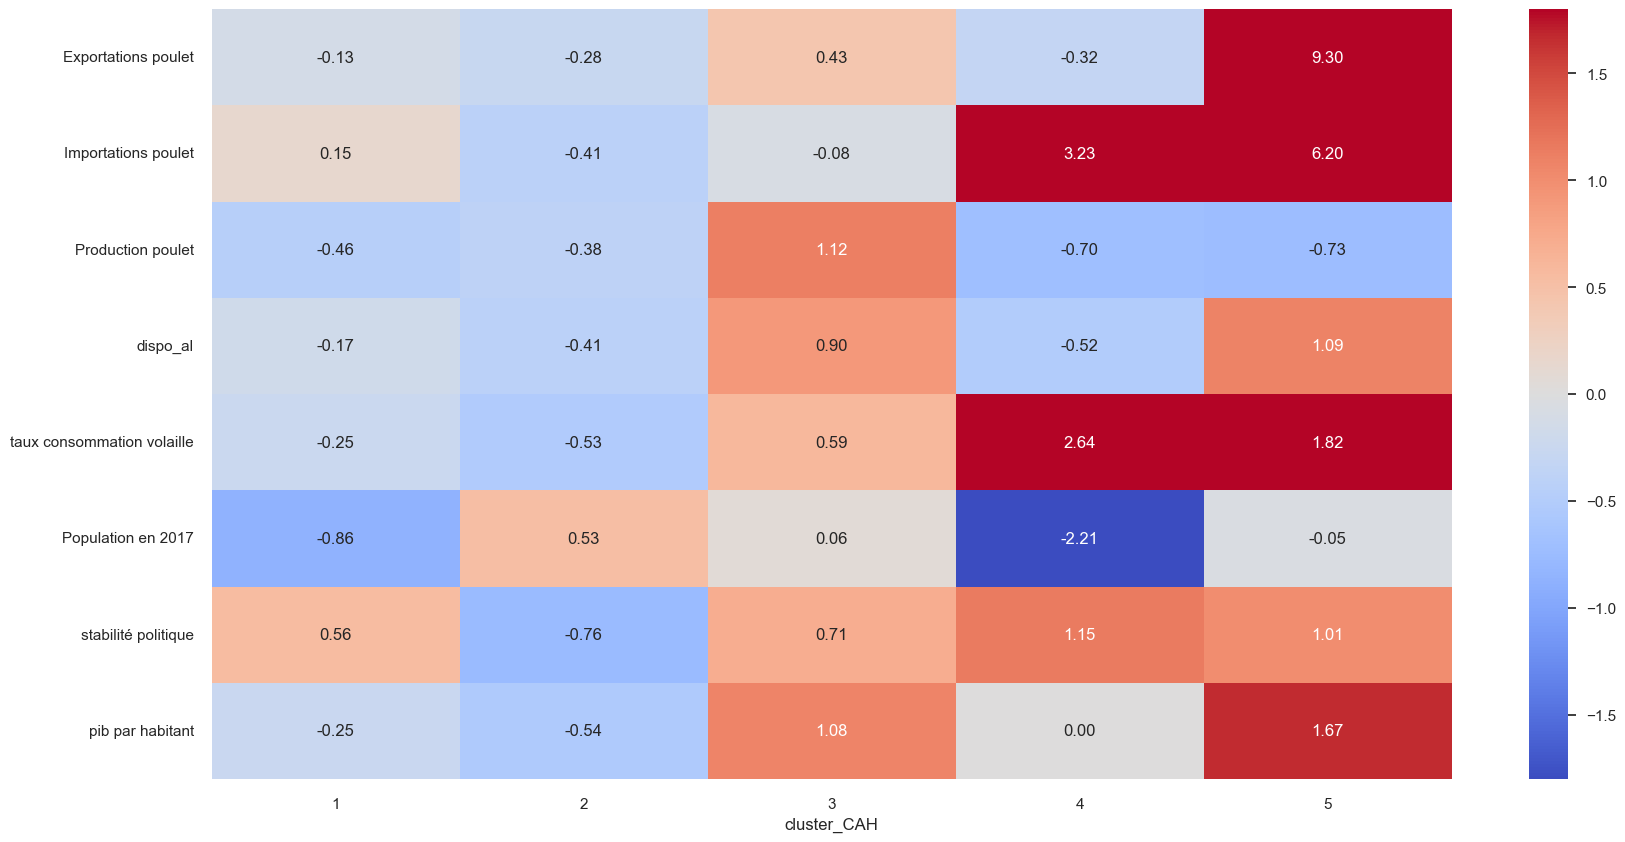

In [59]:
# Représentation sous forme de heatmap
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(cent_CAH_df.T, vmin=-1.8, vmax=1.8, annot=True, cmap="coolwarm", fmt="0.2f")

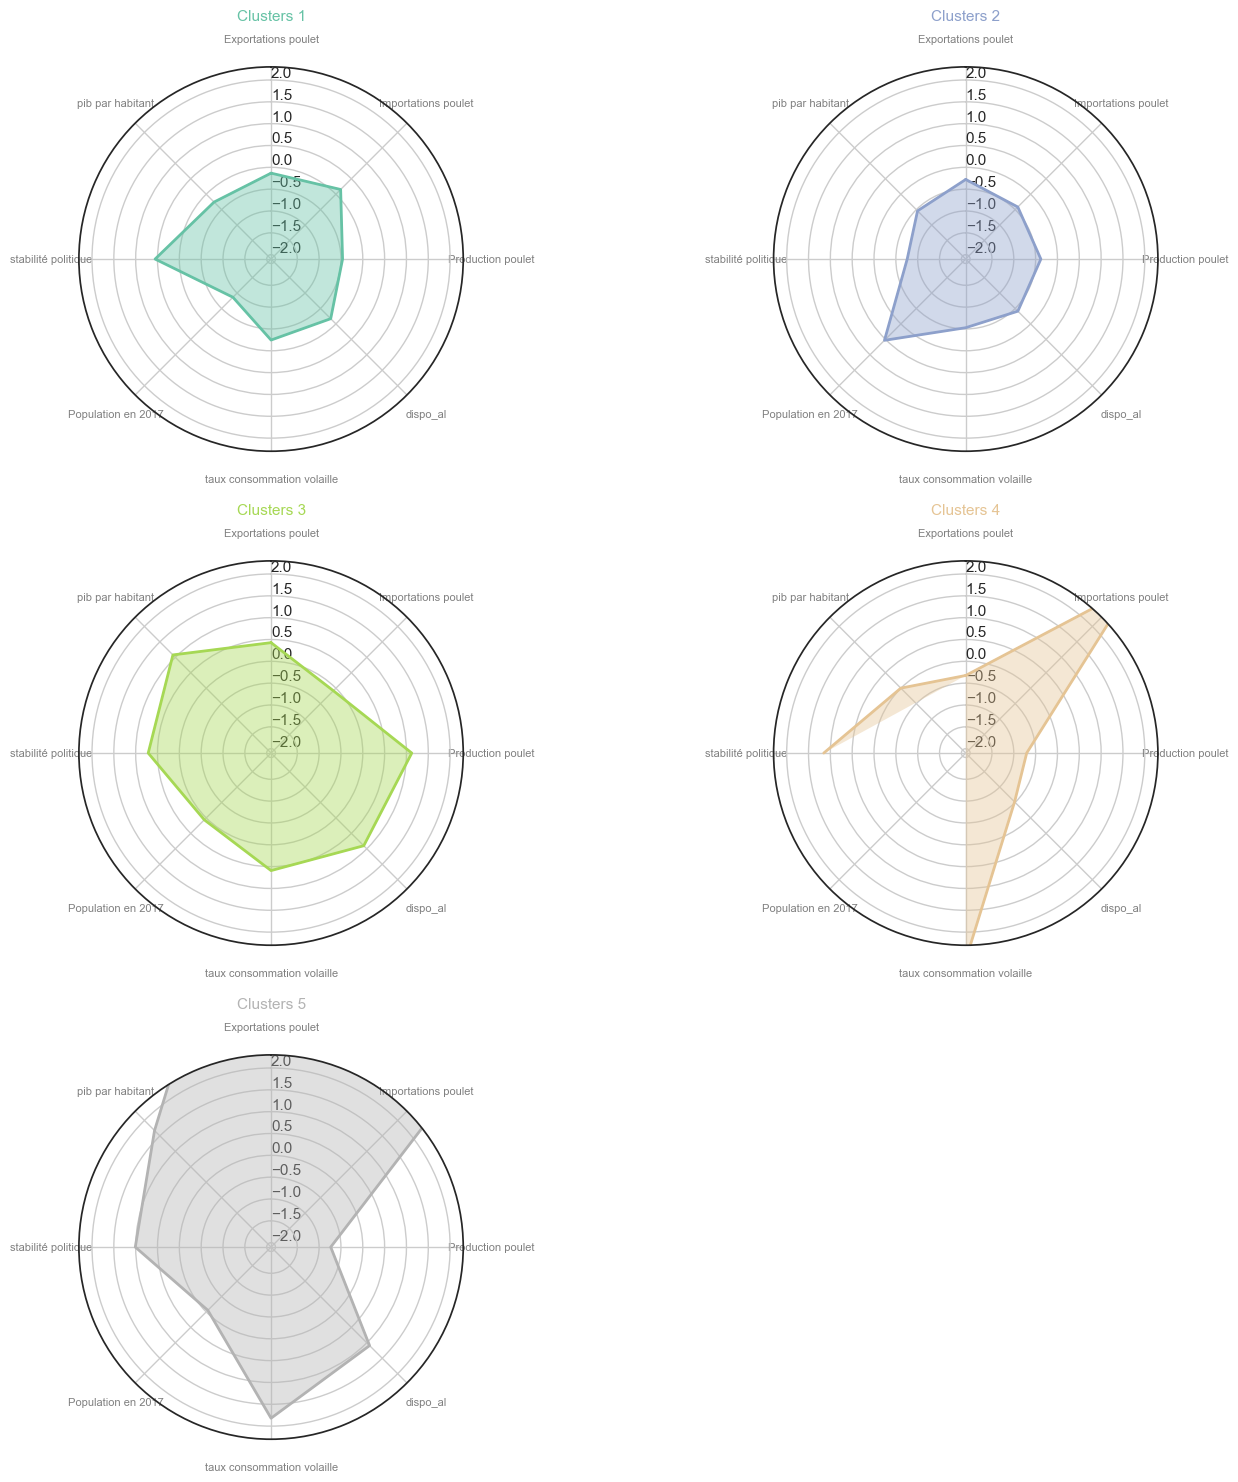

In [60]:
# Représentation des centroïdes sur des radar charts
data = cent_CAH_df.reset_index()
data = data.rename(columns={'index':'cluster_CAH'})
# initialize the figure
plt.figure(figsize=(15, 15))
 
# Create a color palette:
my_palette = cm.get_cmap("Set2", len(data.index))
 
# Loop to plot
for row in range(0, len(data.index)):
    make_spider(data=data, 
                group='cluster_CAH',
                row=row, 
                title='Clusters '+str(data['cluster_CAH'][row]), 
                color=my_palette(row))

- D'après les radar charts ,on constate que: 
- **Les clusters 1 et 2** ne peuvent pas être une cible car ils présentent une forte population,Pib par habitant assez faible aussi bien que le taux d'importation du poulet et sont des pays instables.
- **Les clusters 4 et 5** peuvent contenir quelques pays cibles mais la majorité des pays de ces clusters ne sont pas des cibles.
- **Le cluster 3** est la meilleure cible potentielle.

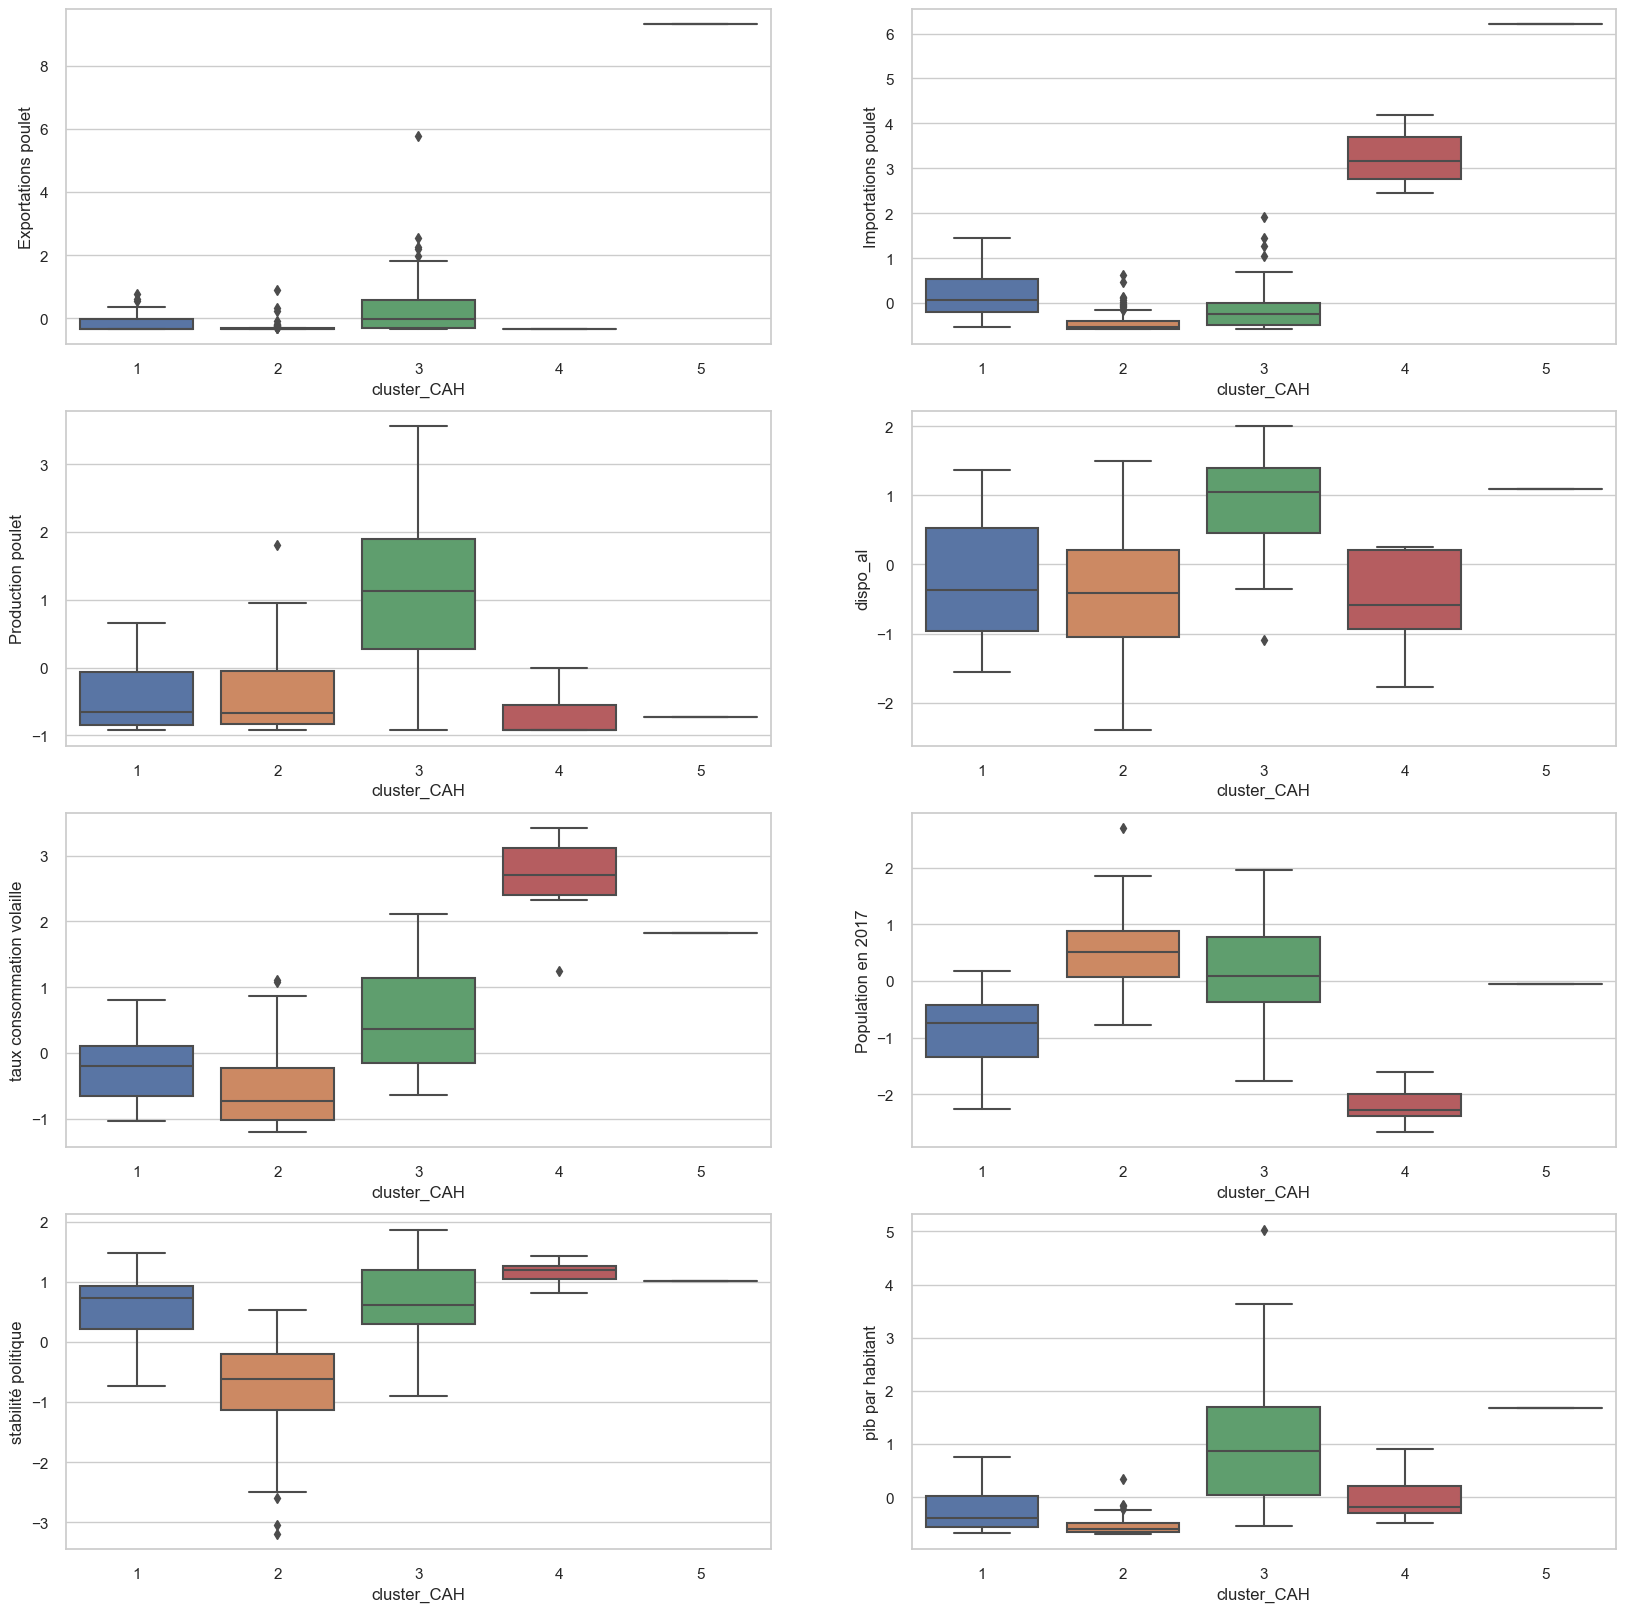

In [61]:
# Tracé des boîtes à moustaches
plt.figure(figsize=(20, 20))
sns.set(style="whitegrid")

plt.subplot(4, 2, 1)
sns.boxplot(data=df_scaled, x='cluster_CAH', y='Exportations poulet')

plt.subplot(4, 2, 2)
sns.boxplot(data=df_scaled, x='cluster_CAH', y='Importations poulet')

plt.subplot(4, 2, 3)
sns.boxplot(data=df_scaled, x='cluster_CAH', y='Production poulet')

plt.subplot(4, 2, 4)
sns.boxplot(data=df_scaled, x='cluster_CAH', y='dispo_al')

plt.subplot(4, 2, 5)
sns.boxplot(data=df_scaled, x='cluster_CAH', y='taux consommation volaille')

plt.subplot(4, 2, 6)
sns.boxplot(data=df_scaled, x='cluster_CAH', y='Population en 2017')

plt.subplot(4, 2, 7)
sns.boxplot(data=df_scaled, x='cluster_CAH', y='stabilité politique')

plt.subplot(4, 2, 8)
sns.boxplot(data=df_scaled, x='cluster_CAH', y='pib par habitant')

plt.show()

**D'après les boxplots,on constate que les pays du cluster 3 et 4 sont retenus sur le critère d importation poulet,taux de consommation de volaille,dispo_alimentaire , mais également sur la stabilité politique.
Les données moyennes et les visualisations graphiques suggèrent que ces deux groupes de pays constituent des cibles favorables pour une entrée sur le marché.**

In [62]:
#Préparation de sous-ensembles permettant de caractériser les groupes un à un
df_cluster1_cah = df_CAH[df_CAH ['cluster_CAH'] == 1]
df_cluster2_cah = df_CAH[df_CAH ['cluster_CAH'] == 2]
df_cluster3_cah = df_CAH[df_CAH ['cluster_CAH'] == 3]
df_cluster4_cah = df_CAH[df_CAH ['cluster_CAH'] == 4]
df_cluster5_cah = df_CAH[df_CAH ['cluster_CAH'] == 5]

In [63]:
#Élaboration d'un premier sous-ensemble des groupes 3 & 5 validés via la classification hiérarchique
df_cah_subset = df_scaled.query('[3, 4] in cluster_CAH') 
df_cah_subset.shape

(54, 9)

In [64]:
# Ajouter la colonne 'pays' aux dataframes des clusters 3 et 4
df_cluster3_cah['pays'] = df_cluster3_cah.index
df_cluster4_cah['pays'] = df_cluster4_cah.index

# Afficher les pays uniques pour les clusters 3 et 4 identifiés comme potentiellement intéressants
print("Pays dans le cluster 3:")
print(df_cluster3_cah['pays'].unique())

print("Pays dans le cluster 4:")
print(df_cluster4_cah['pays'].unique())

Pays dans le cluster 3:
['Allemagne' 'Argentine' 'Australie' 'Autriche' 'Barbade' 'Belgique'
 'Belize' 'Bolivie (État plurinational de)' 'Brésil' 'Bélarus' 'Canada'
 'Chili' 'Chine - RAS de Macao' 'Danemark' 'Espagne' 'Finlande' 'France'
 'Grèce' 'Guyana' 'Hongrie' 'Irlande' 'Islande' 'Israël' 'Italie'
 'Jamaïque' 'Japon' 'Koweït' 'Lituanie' 'Luxembourg' 'Malaisie' 'Maurice'
 'Norvège' 'Nouvelle-Zélande' 'Panama' 'Pologne' 'Portugal' 'Roumanie'
 "Royaume-Uni de Grande-Bretagne et d'Irlande du Nord"
 'République de Corée' 'République dominicaine' 'Slovénie' 'Suisse'
 'Suède' 'Trinité-et-Tobago' 'Émirats arabes unis' "États-Unis d'Amérique"]
Pays dans le cluster 4:
['Antigua-et-Barbuda' 'Bahamas' 'Dominique' 'Grenade'
 'Saint-Kitts-et-Nevis' 'Saint-Vincent-et-les Grenadines' 'Sainte-Lucie'
 'Samoa']


C:\Users\MAHJOUB Samira\AppData\Local\Temp\ipykernel_19412\1036651522.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cluster3_cah['pays'] = df_cluster3_cah.index
C:\Users\MAHJOUB Samira\AppData\Local\Temp\ipykernel_19412\1036651522.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cluster4_cah['pays'] = df_cluster4_cah.index


In [65]:
#Visualisation rapide des premières lignes
df_cah_subset['pays'] =df_cah_subset.index

df_cah_subset.insert(0, 'pays', df_cah_subset.pop('pays'))
df_cah_subset.head()

C:\Users\MAHJOUB Samira\AppData\Local\Temp\ipykernel_19412\3863984285.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cah_subset['pays'] =df_cah_subset.index


,pays,Exportations poulet,Importations poulet,Production poulet,dispo_al,taux consommation volaille,Population en 2017,stabilité politique,pib par habitant,cluster_CAH
pays,,,,,,,,,,
Allemagne,Allemagne,0.505900,-0.013865,0.150250,1.540191,-0.239839,1.232538,0.741606,1.617709,3
Antigua-et-Barbuda,Antigua-et-Barbuda,-0.323152,3.433417,-0.927258,-0.927122,3.424023,-2.350586,0.919869,0.128574,4
Argentine,Argentine,0.176623,-0.559832,1.966116,0.841483,1.507860,0.897775,0.273666,0.050322,3
Australie,Australie,-0.141926,-0.534252,2.109287,0.989958,1.597967,0.590196,1.086991,2.283061,3
Autriche,Autriche,0.614986,0.110850,0.059884,1.834959,-0.353327,0.047169,1.254113,1.761583,3


- **En conclusion,ce partitionnement nous ressort  29 pays qui sont susceptibles de devenir une cible pertinente pour l'entreprise.**

- **Appliquons une autre méthode, celle du K-Means pour pouvoir comparer cette première sélection…**


### <a name="C6"> 3.3 Clustering par la méthode K_means </a>
     Utilisation du package «scikit-learn»

**L'algorithme K-Means est une méthode de clustering non supervisée qui partitionne un ensemble de points en K groupes distincts en minimisant la somme des carrés des distances entre chaque point et le centre de son cluster attribué. Le choix de K, le nombre de clusters, est souvent crucial et peut être évalué avec diverses méthodes comme la méthode du coude ou le coefficient de silhouette**

### <font color='indianred'>Détermination du nombres de clusters</font>

- **Choix du nombre de clusters**

- Différentes méthodes peuvent être utilisées pour déterminer le nombre optimal de clusters k :

- **Méthode du coude sur le distorsion score : distorsion score = moyenne de la somme des carrés des écarts de distances entre les individus d'un cluster et son centroïde**



- **Méthode du coude sur l'inertie : inertie = somme des carrés des écarts de distances entre les individus d'un cluster et son centroïde**


- **Silhouette score / plot : Un graphique de silhouette (Silhouette Plot) visualise ses coefficients pour aider à évaluer le nombre optimal de clusters.. Plus le coefficient de silhouette est élevé, meilleure est la classification.**

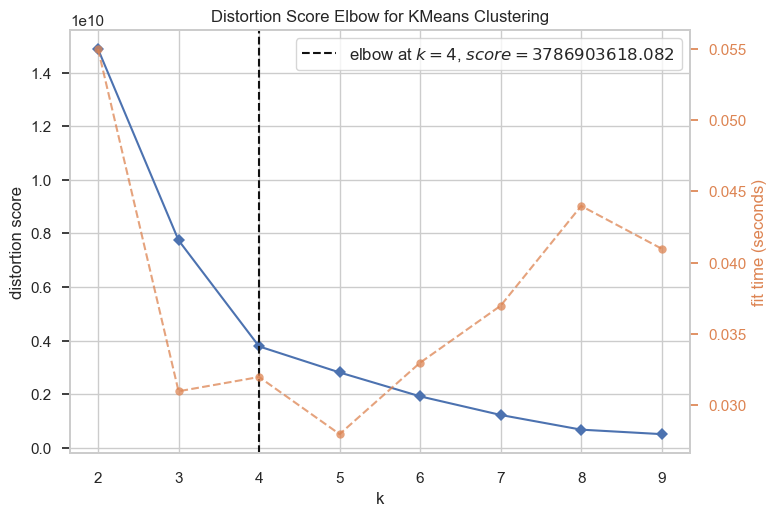

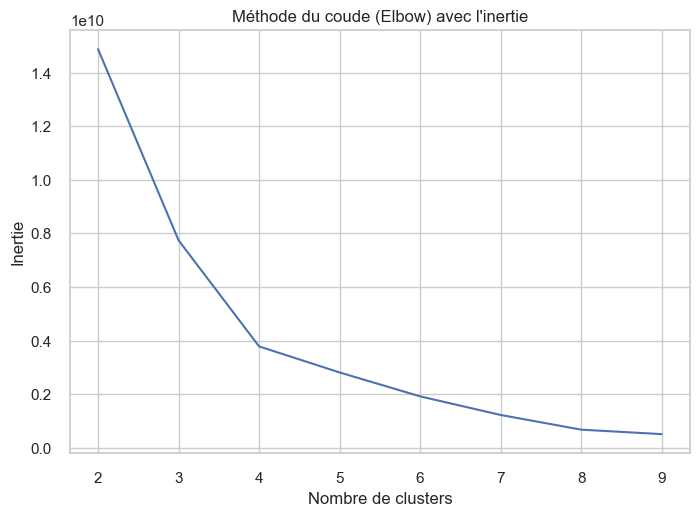

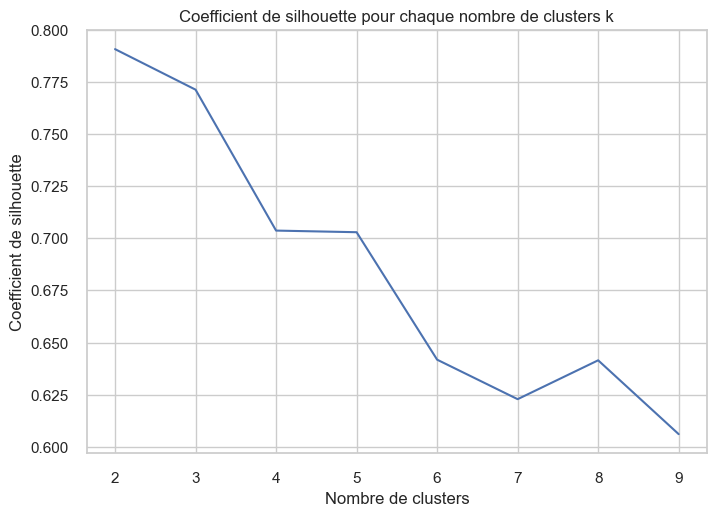

In [66]:
# Instanciation du modèle de clustering et du visualizer
km = KMeans(n_init=10, init='k-means++', random_state=24)
visualizer = KElbowVisualizer(km, k=(2,10))
# Entraînement du visualizer sur les résultats de l'ACP 
visualizer.fit(X)
# Affichage du graphique
visualizer.show()
plt.show()

inertia_scores = []
silhouette_scores = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k,n_init=10, init='k-means++',random_state=24)
    kmeans.fit(X)
    labels = kmeans.labels_
    inertia_scores.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X, labels))

plt.plot(range(2, 10), inertia_scores)
plt.title("Méthode du coude (Elbow) avec l'inertie")
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie')
plt.show()

plt.plot(range(2, 10), silhouette_scores)
plt.title('Coefficient de silhouette pour chaque nombre de clusters k')
plt.xlabel('Nombre de clusters')
plt.ylabel('Coefficient de silhouette')
plt.show()



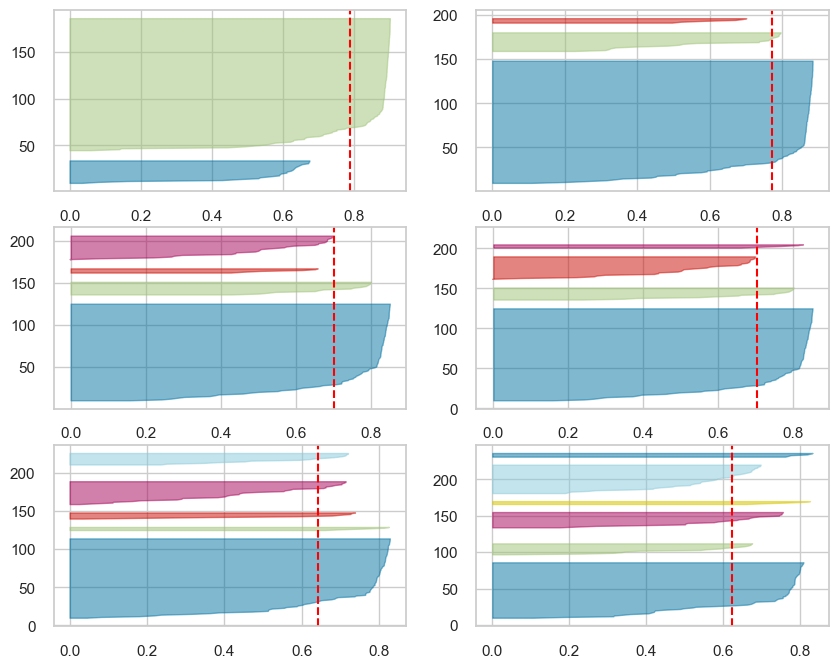

In [67]:
# Méthode du silhouette plot
fig, ax = plt.subplots(3, 2, figsize=(10,8))
for i in [2, 3, 4, 5, 6, 7]:
    # Instanciation du modèle kmeans pour différents nombres de clusters
    km = KMeans(n_clusters=i, n_init=10, init='k-means++',random_state=24)
    q, mod = divmod(i, 2)
    # Instaciation du SilhouetteVisualizer instance 
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    # entraînement du visualizer avec les résultats de l'ACP
    visualizer.fit(X) 

**Résultats :
    Méthode du coude sur le distorsion score = 4 clusters
    Méthode du coude sur l'inertie : 4 clusters
    Silhouette score : 4 clusters
    Silhouette plot : optimum 4 clusters**

**Le nombre de clusters est donc fixé à 4.**

**La méthode du coude nous révèle le nombre optimal de clusters à retenir.
Dans notre cas, on prendra cinq clusters.
On constate une chute de l'inertie en passant de 1 à 3 clusters, mais cette baisse s'atténue à partir de 4.**

### <font color='indianred'>Standardistion des données</font>

In [68]:
# Nombre de clusters
k =5

In [69]:
# Instaciation et Entraînement du modèle k-means
kmeans = KMeans(n_clusters=k,n_init=10, init='k-means++', random_state=24)
kmeans.fit(X_scaled)

# Stockage des clusters dans la variable labels
labels = kmeans.labels_

# Stockage des centroids dans une variable
centroids = kmeans.cluster_centers_
df_final['cluster']=labels+1


In [30]:
# Nombre de pays par cluster
unique, counts = np.unique(labels+1, return_counts=True)

dict(zip(unique, counts))

{1: 76, 2: 41, 3: 40, 4: 2, 5: 8}

### <font color='indianred'>Projection des clusters sur le premier plan factoriel</font>

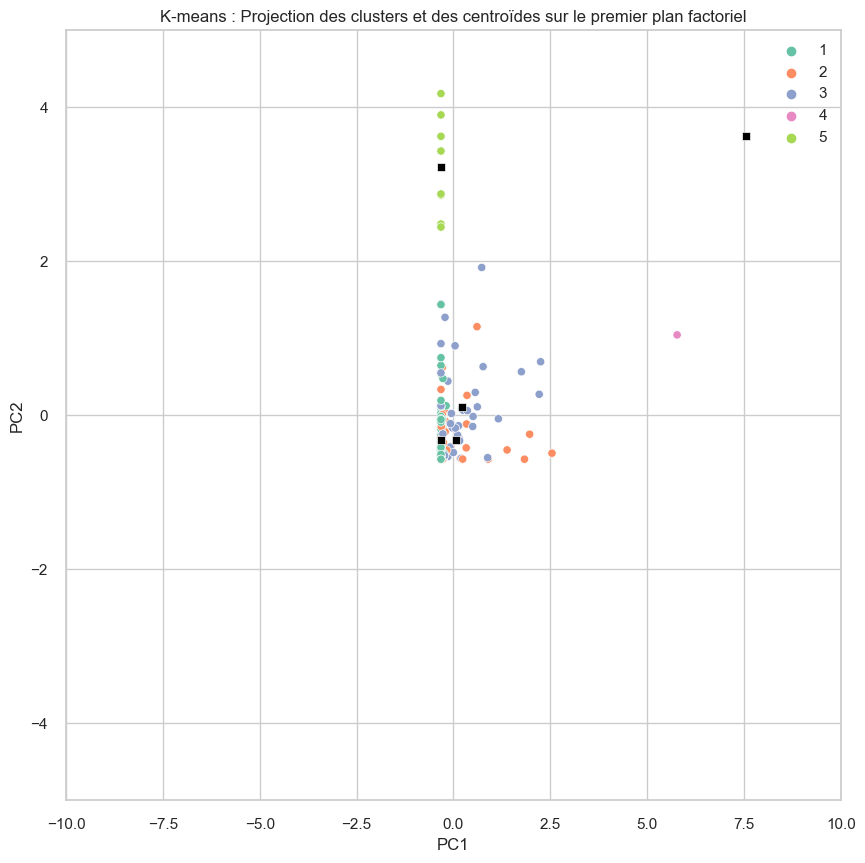

In [31]:
# Affichage des clusters sur le premier plan factoriel de l'ACP
fig, ax = plt.subplots(1,1, figsize=(10,10))# Définition figure et axe

sns.scatterplot(data=None, x=X_scaled[:, 0],y=X_scaled[:,1], 
                hue=labels+1, palette='Set2', ax=ax)# Affichage des individus
sns.scatterplot(data=None, x=centroids[:, 0], y=centroids[:, 1],  marker="s", color="black", ax=ax)# Affichage des centroïdes

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_title("K-means : Projection des clusters et des centroïdes sur le premier plan factoriel")
plt.xlim(-10,10)
plt.ylim(-5,5)
plt.show()

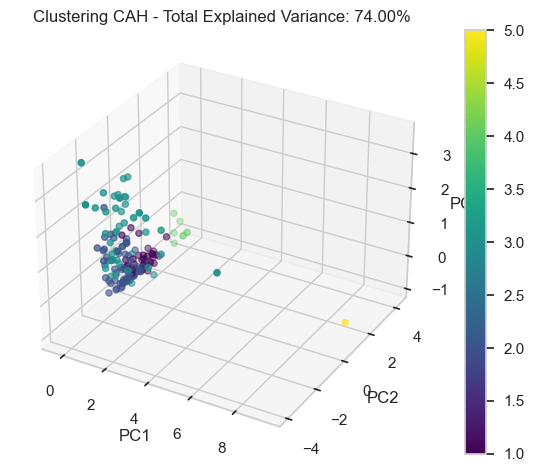

In [32]:
# Créer une nouvelle figure
fig = plt.figure()

# Ajouter des axes 3D
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
sc = ax.scatter(X_scaled[:, 0], X_proj[:, 1], X_scaled[:, 2], c=clusters, cmap='viridis')

# Ajouter des labels et un titre
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.title(f'Clustering CAH - Total Explained Variance: {scree.iloc[2,3]:.2f}%')

# Afficher la colorbar
plt.colorbar(sc)

# Montrer le plot
plt.show()

**On identifie les caractéristiques de chaque cluster en fonction de nos variables. Les positions des centroïdes nous guideront pour déterminer les clusters les plus pertinents. C'est l'un des avantages de l'usage du K-Means : il génère directement des centroïdes qui sont des valeurs centrées et normalisées, ce qui simplifie l'analyse subséquente.**

In [33]:
# Création d'un dataframe cluster k-means
df_kmeans = df_final.copy()
df_kmeans['cluster_kmeans'] = labels+1
df_kmeans.head()

,Exportations poulet,Importations poulet,Production poulet,dispo_al,taux consommation volaille,Population en 2017,stabilité politique,pib par habitant,cluster,cluster_kmeans
pays,,,,,,,,,,
Afghanistan,0.000000,0.798984,0.771432,1997,0.250376,10.499466,-2.80,530.149831,1,1
Afrique du Sud,1.105074,9.016001,29.240609,2987,4.787412,10.950978,-0.28,6723.928582,2,2
Albanie,0.000000,13.175372,4.507364,3400,2.500000,7.966992,0.38,4521.752219,3,3
Algérie,0.000000,0.048322,6.644247,3345,0.657698,10.630775,-0.92,4134.936054,1,1
Allemagne,7.815297,10.186501,18.316346,3559,1.994942,11.322472,0.59,44670.222288,3,3


### <font color='indianred'>Identification des pays de chaque cluster</font>

In [34]:
# Liste des individus de chaque cluster
for i in range(1,k+1):
    print('cluster '+str(i)+': '+str(len(df_final.loc[df_final['cluster']==i].index))+' pays')
    print(df_final.loc[df_final['cluster']==i].index)    
    print('-'*100)


cluster 1: 76 pays
Index(['Afghanistan', 'Algérie', 'Angola', 'Arménie', 'Azerbaïdjan',
       'Bangladesh', 'Botswana', 'Burkina Faso', 'Bénin', 'Cabo Verde',
       'Cambodge', 'Cameroun', 'Congo', 'Côte d'Ivoire', 'Djibouti',
       'Eswatini', 'Gabon', 'Gambie', 'Ghana', 'Guatemala', 'Guinée',
       'Guinée-Bissau', 'Géorgie', 'Haïti', 'Inde', 'Indonésie', 'Iraq',
       'Kazakhstan', 'Kenya', 'Kirghizistan', 'Lesotho', 'Liban', 'Libéria',
       'Macédoine du Nord', 'Madagascar', 'Malawi', 'Maldives', 'Mali',
       'Mauritanie', 'Mongolie', 'Mozambique', 'Namibie', 'Niger', 'Nigéria',
       'Népal', 'Ouganda', 'Ouzbékistan', 'Pakistan', 'Paraguay',
       'Philippines', 'Rwanda', 'République centrafricaine',
       'République de Moldova', 'République démocratique populaire lao',
       'République populaire démocratique de Corée',
       'République-Unie de Tanzanie', 'Sao Tomé-et-Principe', 'Serbie',
       'Sierra Leone', 'Soudan', 'Sri Lanka', 'Sénégal', 'Tadjikistan',
    

### <font color='indianred'>Analyses des centroîdes</font>

In [35]:
# Mettre à jour les features
features = df_final.select_dtypes(exclude=['object']).columns.tolist()

# Convertir seulement les colonnes numériques en array numpy
X = df_final.select_dtypes(exclude=['object']).values

# Utilisation de StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convertir le résultat en DataFrame et utiliser l'index de df_final
df_scaled = pd.DataFrame(X_scaled, columns=features, index=df_final.index)

# Ajouter les clusters (Si vous avez déjà la colonne 'cluster', cette étape n'est pas nécessaire)
df_scaled['cluster_kmeans'] = labels+1
df_scaled = df_scaled.drop('cluster', axis=1)
# Calculer les moyennes des clusters
cent_kmeans_df = df_scaled.groupby(['cluster_kmeans']).mean()
cent_kmeans_df

,Exportations poulet,Importations poulet,Production poulet,dispo_al,taux consommation volaille,Population en 2017,stabilité politique,pib par habitant
cluster_kmeans,,,,,,,,
1,-0.309689,-0.319189,-0.703846,-0.703173,-0.725910,0.189627,-0.574990,-0.573652
2,0.052782,-0.314801,1.138114,0.301635,0.690606,0.158268,-0.113567,-0.224183
3,0.222098,0.102690,0.293590,1.053279,0.114221,-0.083998,0.939367,1.237672
4,7.536771,3.625141,0.361910,1.545650,0.589691,0.065726,0.786172,1.632291
5,-0.323152,3.225912,-0.704724,-0.518541,2.638266,-2.209024,1.151054,0.002195


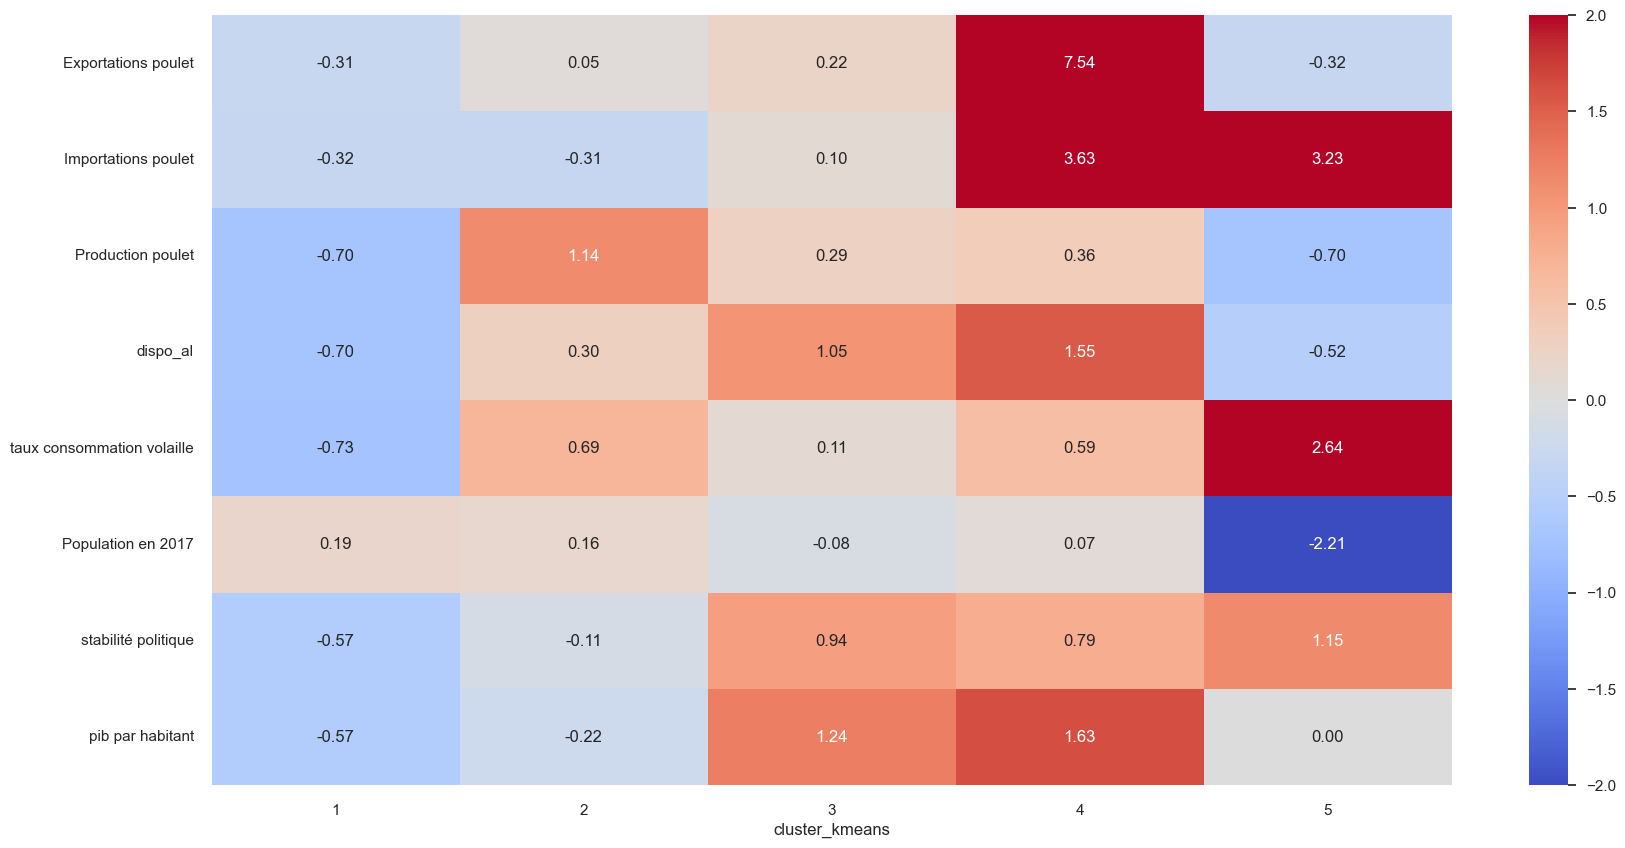

In [36]:
# Représentation sous forme de heatmap
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(cent_kmeans_df.T, vmin=-2, vmax=2, annot=True, cmap="coolwarm", fmt="0.2f")
plt.show()

- Le cluster 1 se caractérise par une forte population ainsi qu'un pib par habitant et stabilité politique très faible(Afrique).
- Le cluster 2 se caractérise par un fort taux de production  et une population assez importante mais importation relativement faible.
- Le cluster 3 présentepar un taux d'importation de poulet moyennement important ainsi qu'une richechees importante et une stabilité politique elevé t et une population faible.
- Le cluster 4 présente également un potentiel marché intéressant toujours sur l'idée d'un régime alimentaire potentiellement compatible avec les besoins en poulet:ce dernier est éventuellemnt intéressant pour notre étude.
- Le cluster 5 présente des pays qui sont des gros importateurs et consommateurs deu poulet :ce cluster nous interesse moins car ilse caractérise par une population très faible(les îles).

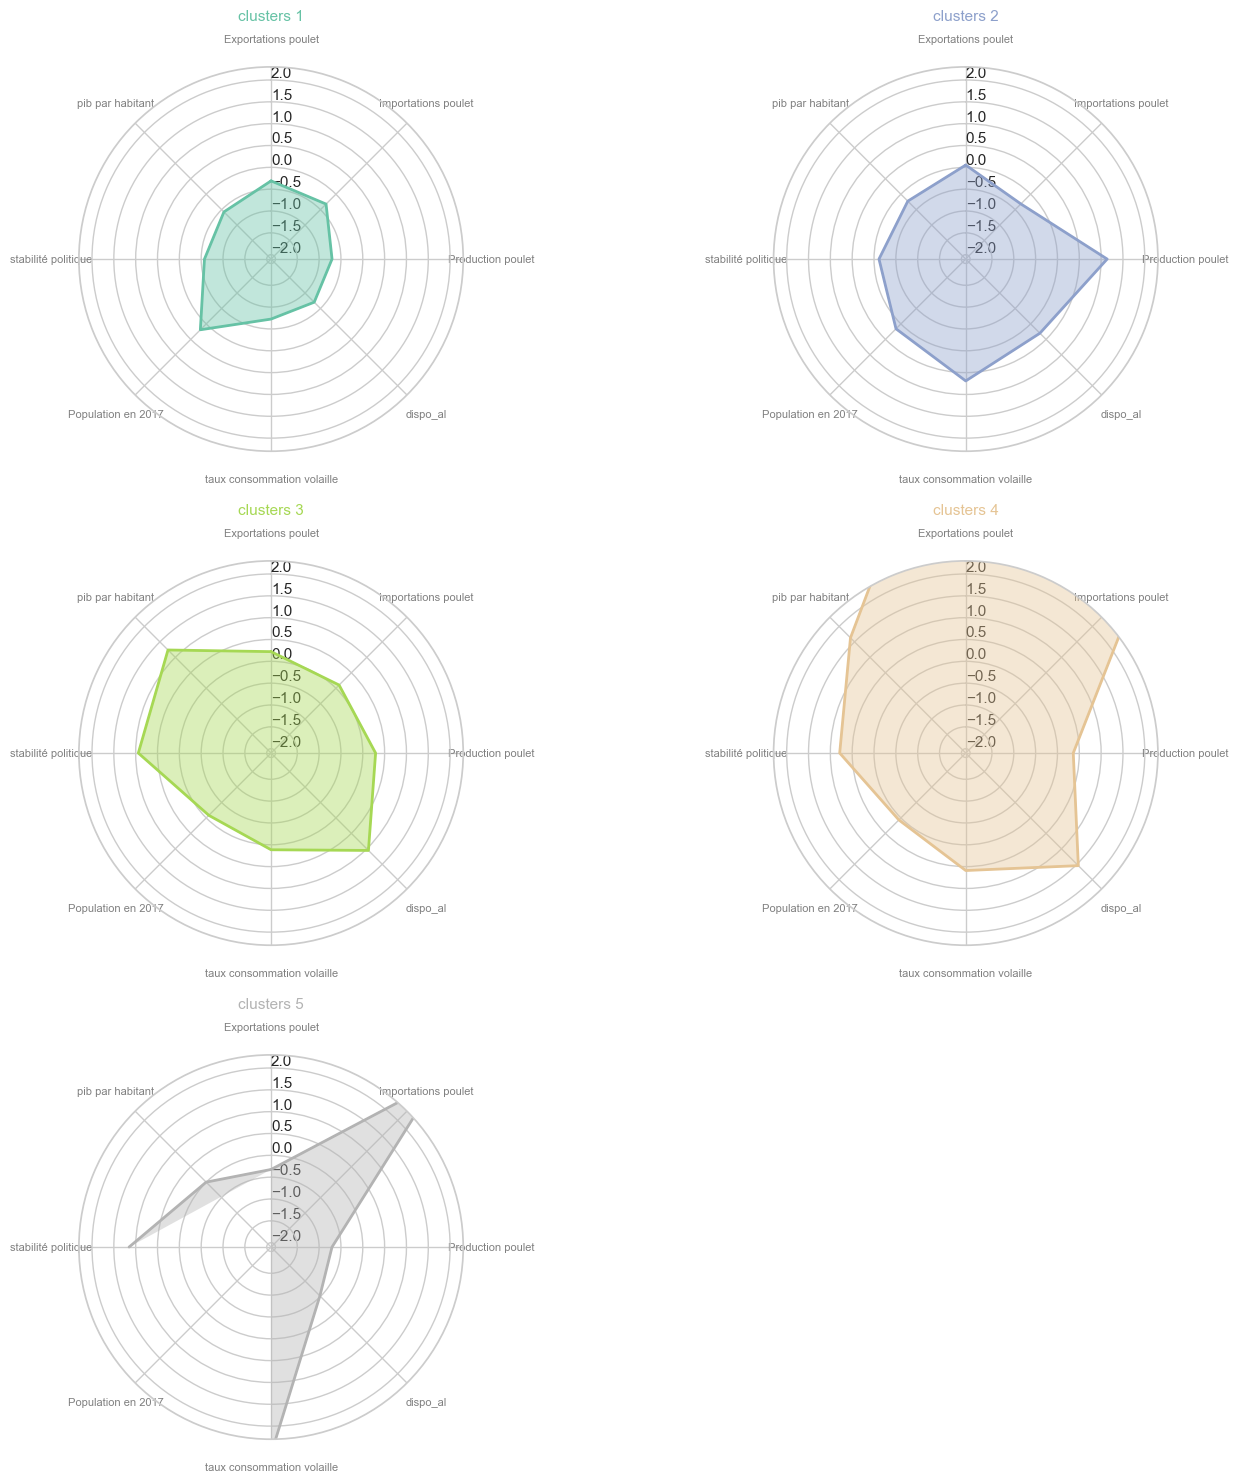

In [37]:
# Représentation des centroïdes sur des radar charts
data = cent_kmeans_df.reset_index()
data = data.rename(columns={'index':'cluster_kmeans'})
# initialize the figure
plt.figure(figsize=(15, 15))
 
# Create a color palette:
my_palette = cm.get_cmap("Set2", len(data.index))
 
# Loop to plot
for row in range(0, len(data.index)):
    make_spider(data=data, 
                group='cluster_kmeans',
                row=row, 
                title='clusters '+str(data['cluster_kmeans'][row]), 
                color=my_palette(row))

**Nous constatons des similitudes entre les groupes formés par les deux méthodes, CAH et k-means.**

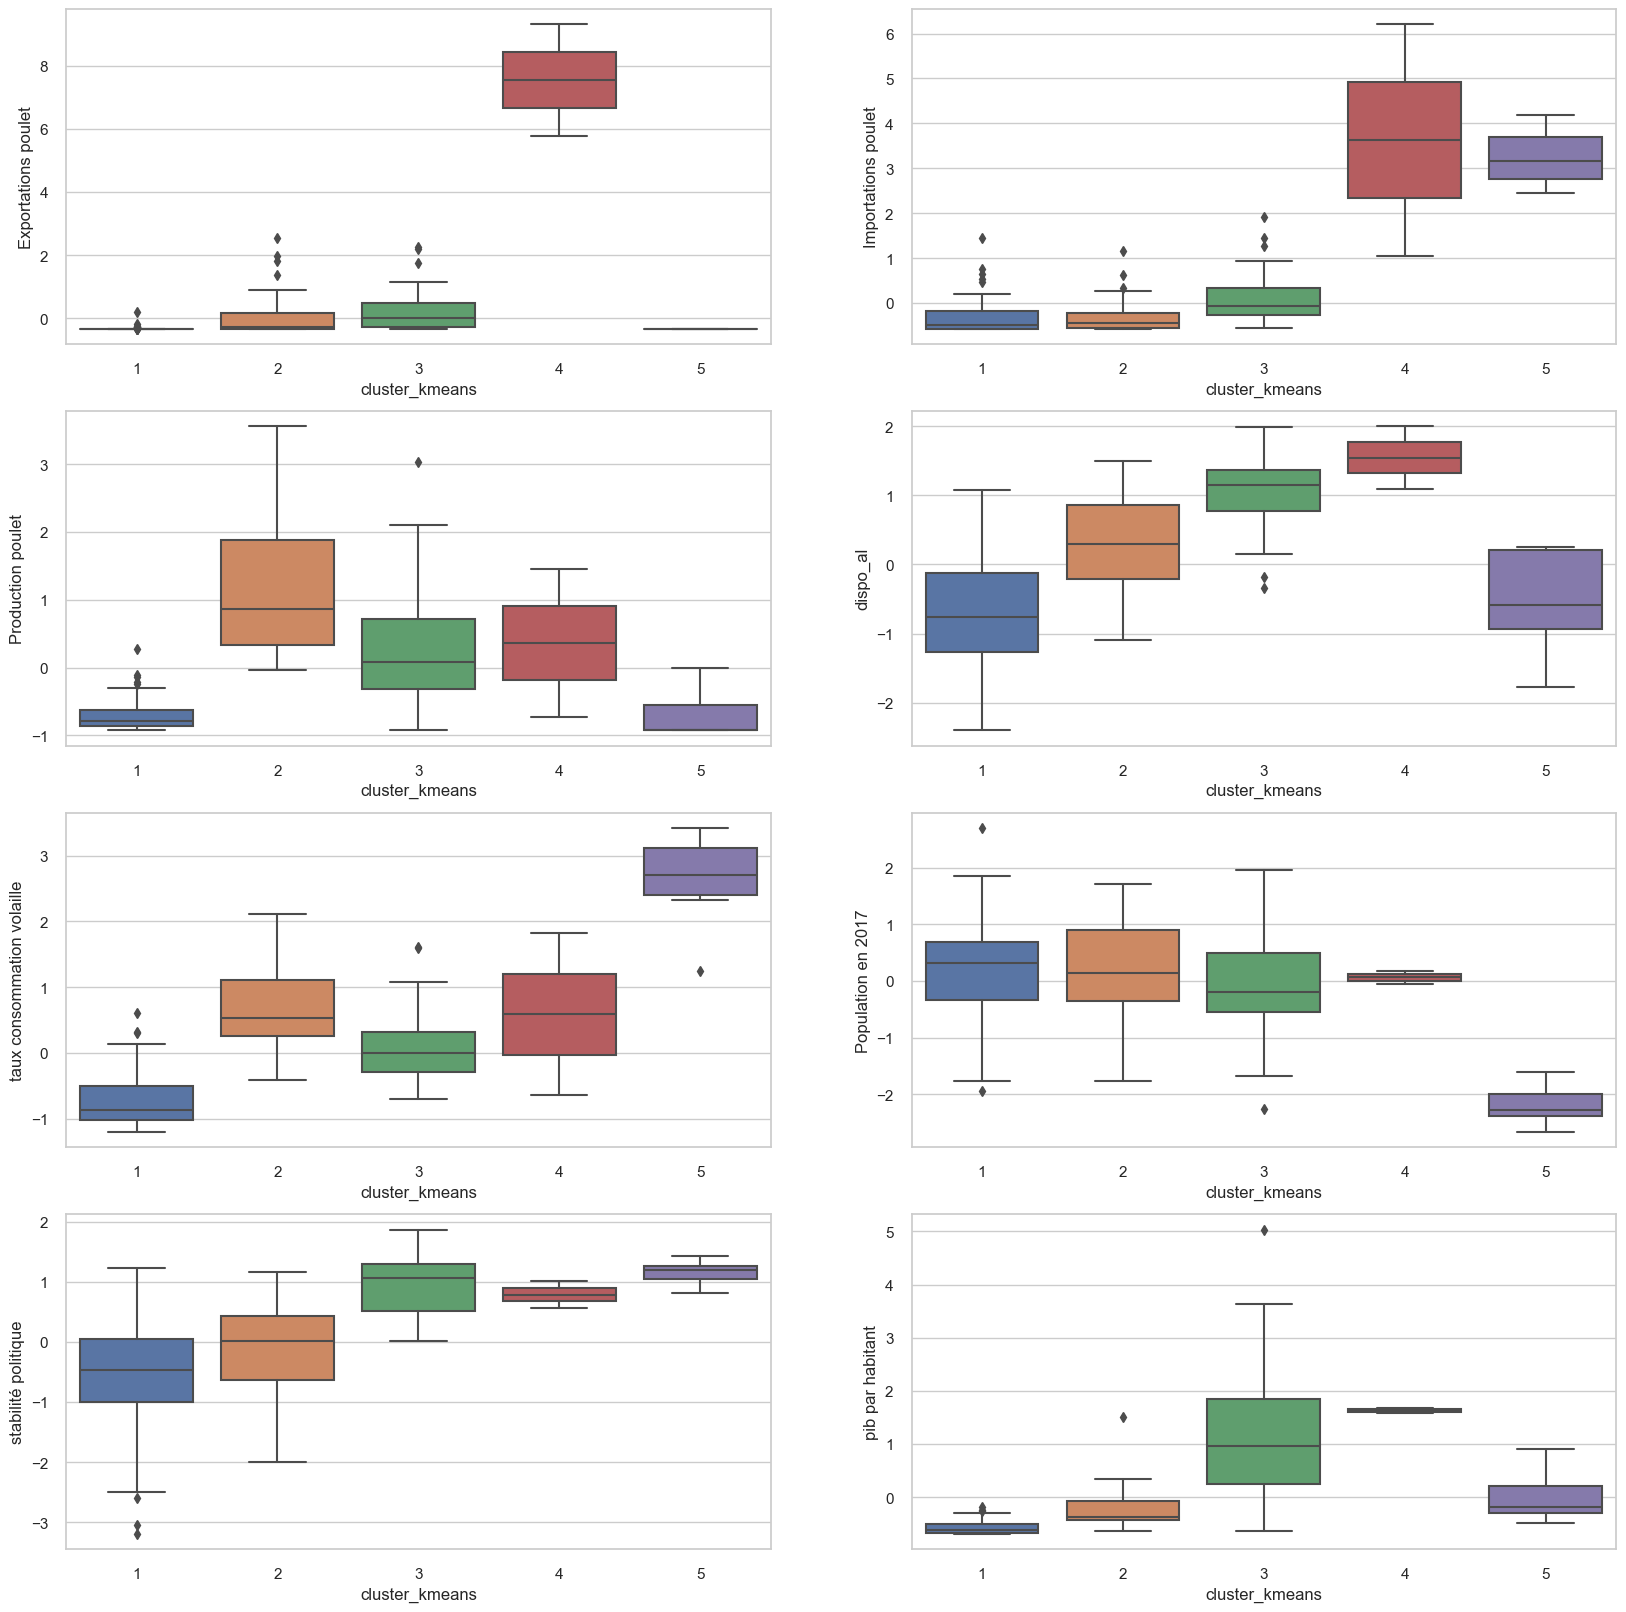

In [38]:
plt.figure(figsize=(20, 20))
sns.set(style="whitegrid")

plt.subplot(4, 2, 1)
sns.boxplot(data=df_scaled, x='cluster_kmeans', y='Exportations poulet')

plt.subplot(4, 2, 2)
sns.boxplot(data=df_scaled, x='cluster_kmeans', y='Importations poulet')

plt.subplot(4, 2, 3)
sns.boxplot(data=df_scaled, x='cluster_kmeans', y='Production poulet')

plt.subplot(4, 2, 4)
sns.boxplot(data=df_scaled, x='cluster_kmeans', y='dispo_al')

plt.subplot(4, 2, 5)
sns.boxplot(data=df_scaled, x='cluster_kmeans', y='taux consommation volaille')

plt.subplot(4, 2, 6)
sns.boxplot(data=df_scaled, x='cluster_kmeans', y='Population en 2017')

plt.subplot(4, 2, 7)
sns.boxplot(data=df_scaled, x='cluster_kmeans', y='stabilité politique')

plt.subplot(4, 2, 8)
sns.boxplot(data=df_scaled, x='cluster_kmeans', y='pib par habitant')

plt.show()

### <a name="C7"> 3.4 Quelle méthode de clustering choisir ? </a>

**Nous avons utilisé deux méthodes de clustering, CAH et K-means, pour créer des groupes. Pour décider quel set de clusters examiner plus en détail, nous avons utilisé les indicateurs de qualité Davies-Bouldin et le coefficient de silhouette.**


In [39]:
from sklearn import datasets
from sklearn import cluster, metrics

# Calcul de l'indice de Davies-Bouldin
print("\033[1mIndice de Davies-Bouldin:\033[0m")
print("Classification hiérarchique:", round(metrics.davies_bouldin_score(X_scaled,clusters), 3))
print("Kmeans:", round(metrics.davies_bouldin_score(X_scaled,labels+1), 3))

print("----------------------------------")

# Calcul du coefficient de silhouette
print("\033[1mCoefficient de silhouette:\033[0m")
print("Classification hiérarchique:", round(metrics.silhouette_score(X_scaled,clusters), 3))
print("Kmeans:", round(metrics.silhouette_score(X_scaled,labels+1), 3))



Indice de Davies-Bouldin:
Classification hiérarchique: 1.086
Kmeans: 1.13
----------------------------------
Coefficient de silhouette:
Classification hiérarchique: 0.226
Kmeans: 0.316


**Indice de Davies-Bouldin: Plus cette valeur est faible, mieux c'est. Elle mesure la moyenne de la «similitude» entre chaque cluster et son cluster le plus similaire. La similitude est le rapport de la distance intra-cluster à la distance inter-cluster.**

    Classification hiérarchique: 1.086
    Kmeans: 1.13
    Interprétation : La Classification hiérarchique estpresque similaire selon cet indice.

**Coefficient de Silhouette: Les valeurs vont de -1 à 1. Une valeur élevée indique que l'objet est bien assorti à sa propre grappe et mal assorti aux grappes voisines.**

    Classification hiérarchique: 0.226
    Kmeans: 0.316
    Interprétation: Kmeans est nettement meilleur selon cette métrique.
**À partir de ces informations, on décide de poursuivre l'analyse avec les clusters du K-means.**    

### <a name="C8">3.5 Conclusion </a>

À l'aide du nuage de point, des boxplot et de la heatmap ci-dessus nous pouvons décrire les clusters ainsi:

    Cluster 1= pays instables, à faible/moyen revenu, autosuffisant en volaille et forte population (générallement sont les pays africains)
    
    Cluster 2= Taux de dépendance aux importations faible,PIB et stabilité politique faible,mais sont des bon producteurs et consommateurs de poulets.
    
    Cluster 3= pays riches (à revenu moyen supérieur et haut),taux d'importation de poulet moyennement important,stabilité politique et PIB relativement élevée et leurs habitants sont des gros consommateurs de volailles(forte disponibilté alimentaire)
    
    Cluster 4=pays qui font de l'import / export, stables et à revenu moyen élevé
    Il ont des taux de dépendance aux importations acceptables relativement à d'autre groupes de pays

    Cluster 5 =  Taux de dépendance aux importations relativement élevé,gros consommateurs de volailles mais population très faible.(génerallement sont les îles)
    
**Pays cibles :**

   **Le cluster 3 est recommandé pour l'exportation des volailles ainsi que Hong-Kong qui est inclus dans le cluster 4**
    
    les pays de ces deux clusters présentent:
    
   - des stabilités politiques très élevées
   - Leurs habitants sont des gros consommateurs de volailles (fortes disponibilités alimentaires et part de protéines animales).
  
   - Ils ont des taux de dépendance aux importations acceptables relativement à d'autre groupes de pays.